In [3]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
from visualization import *
from capsnet import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 1000

PATH_MNISTC = '../data/MNIST_C/'
CORRUPTION_TYPES = ['identity', 
         'shot_noise', 'impulse_noise','glass_blur','motion_blur',
         'shear', 'scale',  'rotate',  'brightness',  'translate',
         'stripe', 'fog','spatter','dotted_line', 'zigzag',
         'canny_edges']


# general helper funtions for model testing
def load_model(args):
    # load model
    model = CapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

def test_model(task, model, args, verbose=False):
    # set task and print setting
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    
    # get test results
    model.eval()
    test_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train=False)
    test_loss, test_loss_class, test_loss_recon, test_acc = test(model, test_dataloader, args, acc_name="top@1")
    if verbose:
        print("==> test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (test_loss, test_loss_class, test_loss_recon, test_acc))
    return test_loss, test_loss_class, test_loss_recon, test_acc

# helper funtions for model testing on mnist-C
def test_model_mnistc(path_mnistc, corruptionlist, model, verbose=False):
    # set task and print setting
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    
    # get average test results over corruptionlist   
    losses, classlosses, reconlosses, accs = [], [], [], []
    for corruption in corruptionlist:
        test_loss, test_loss_class, test_loss_recon, test_acc = test_model_on_each_corruption(path_mnistc, corruption, model, verbose)

        losses.append(test_loss)
        classlosses.append(test_loss_class)
        reconlosses.append(test_loss_recon)
        accs.append(test_acc)
    
    avgtest_loss = sum(losses)/len(corruptionlist)
    avgtest_loss_class = sum(classlosses)/len(corruptionlist)
    avgtest_loss_recon = sum(reconlosses)/len(corruptionlist)
    avgtest_acc = sum(accs)/len(corruptionlist)
    
    if verbose:
        print("==> average test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (avgtest_loss, avgtest_loss_class, avgtest_loss_recon, avgtest_acc))
        
    return avgtest_loss, avgtest_loss_class, avgtest_loss_recon, avgtest_acc
    
def test_model_on_each_corruption(path_mnistc, corruption, model, verbose=False):
    path_images = os.path.join(path_mnistc, corruption, 'test_images.npy')
    path_labels = os.path.join(path_mnistc, corruption, 'test_labels.npy')

    # convert to torch
    images = np.load(path_images)
    labels = np.load(path_labels)
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    # print(images_tensorized.shape) #torch.Size([10000, 1, 28, 28])
    # print(labels_tensorized.shape) #torch.Size([10000, 10])

    # create dataloader
    kwargs = {'num_workers': 1, 'pin_memory': True} if DEVICE == 'cuda' else {}
    dataset = TensorDataset(images_tensorized, labels_tensorized)
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=False, drop_last=False, **kwargs)

    # test on the dataloder
    model.eval()
    test_loss, test_loss_class, test_loss_recon, test_acc = test(model, dataloader, args, acc_name="top@1")

    if verbose:
        print("==> individual test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (test_loss, test_loss_class, test_loss_recon, test_acc))
    return test_loss, test_loss_class, test_loss_recon, test_acc

@torch.no_grad()
def evaluate_on_batch(task, batchnum, model, args, train=False, verbose=True, onlyacc=False):
    
    # evaluate on one train/test batch 
    model.eval()
    
    if task == 'mnist_recon':
        # for mnist recon data, it has erased input(x) and intact input (gtx)
        if train:
            dataloader, val_dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)
        else:
            dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)            
        diter = iter(dataloader)
        for i in range(batchnum):
            x, gtx, y = next(diter)
    else:
        dataloader = fetch_dataloader(task, DATA_DIR, DEVICE, BATCHSIZE, train)    
        diter = iter(dataloader)
        for i in range(batchnum):
            x, y = next(diter)
            gtx = None
            
            
    # attach forward hooks for intermediate outputs for visualizations
    outputs = {}
    
    # from model main output
    x_input_step = []; x_mask_step = []; objcaps_step = []
#     affine_params_step=[]
    
    # from model dynamic routing
    coups_step = []; betas_step= []; rscores_step=[]; recon_coups_step=[] 
    outcaps_len_step=[]; outcaps_len_before_step=[]

#     def get_attention_outputs():
#         def hook(model, input, output):
#             x_mask_step.append(output[0].detach())
#             x_input_step.append(output[1].detach())
#         return hook

    def get_capsule_outputs():
        def hook(model, input, output):
            objcaps_step.append(output[0].detach())
            coups_step.append(torch.stack(output[1]['coups'], dim=1))
            betas_step.append(torch.stack(output[1]['betas'], dim=1)) 
            if 'rscores' in output[1].keys():
                rscores_step.append(torch.stack(output[1]['rscores'], dim=1))
            if 'recon_coups' in output[1].keys():
                recon_coups_step.append(torch.stack(output[1]['recon_coups'], dim=1))
            if 'outcaps_len' in output[1].keys():
                outcaps_len_step.append(torch.stack(output[1]['outcaps_len'], dim=1))
            if 'outcaps_len_before' in output[1].keys():
                outcaps_len_before_step.append(torch.stack(output[1]['outcaps_len_before'], dim=1))
        return hook
    

#     hook1 = model.input_window.register_forward_hook(get_attention_outputs())
    hook2 = model.capsule_routing.register_forward_hook(get_capsule_outputs())
    
    # evaluate and detach hooks
    losses, acc, objcaps_len_step, x_recon_step = evaluate(model, x, y, args, acc_name='top@1', gtx=gtx)
#     hook1.remove()
    hook2.remove()
    
    # add tensor outputs dictionary
#     outputs['x_input'] = torch.stack(x_input_step, dim=1)
#     outputs['x_mask'] = torch.stack(x_mask_step, dim=1)
    outputs['objcaps'] = torch.stack(objcaps_step, dim=1)
    
    outputs['coups'] = torch.stack(coups_step, dim=1)
    outputs['betas'] = torch.stack(betas_step, dim=1)
#     if rscores_step:
#         outputs['rscores'] = torch.stack(rscores_step, dim=1)
#     if recon_coups_step:
#         outputs['recon_coups'] = torch.stack(recon_coups_step, dim=1)
#     if outcaps_len_step:
#         outputs['outcaps_len'] = torch.stack(outcaps_len_step, dim=1)
#     if outcaps_len_before_step:
#         outputs['outcaps_len_before'] = torch.stack(outcaps_len_before_step, dim=1)        
    if verbose:
        print("==> On this sigle test batch: test_loss=%.5f, test_loss_class=%.5f, test_loss_recon=%.5f, test_acc=%.4f"
              % (losses[0], losses[1], losses[2], acc))
    
    if onlyacc:
        return acc
    else:
        return x, gtx, y, objcaps_len_step, x_recon_step, outputs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Detailed Acc Results on MNIST-C

In [9]:
########################################################
# best model comparison on entire corruptions
########################################################
path_df = 'model-results-capsnet-clean.csv'
verbose=False
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 'routings': 3}

modellist = [
 './models/capsnet/run1.pt',
 './models/capsnet/run2.pt',
 './models/capsnet/run3.pt',
 './models/capsnet/run4.pt',
 './models/capsnet/run5.pt'
    
]



df = pd.DataFrame()
df['corruption'] = CORRUPTION_TYPES

for load_model_path in modellist:    
#     modelname = '-'.join( os.path.dirname(load_model_path).split('_')[-3:-1]) #'recon-step3'
    modelname = load_model_path.split('/')[-1] # filename
    print(f'test starts on {modelname}')
    
    # load args and model  
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    
    acclist = []
    for corruption in CORRUPTION_TYPES:
        test_loss, test_loss_class, test_loss_recon, test_acc = test_model_on_each_corruption(PATH_MNISTC, corruption, model, verbose)
        acclist.append(test_acc*100)
    df[modelname] = acclist

df.index = np.arange(1, len(df)+1)
df.loc['AVERAGE'] = df.mean()
df

test starts on run1.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
DECODER: True
...recon only one object capsule: True

test starts on run2.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
DECODER: True
...recon only one object capsule: True

test starts on run3.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
DECODER: True
...recon only one object capsule: True

test starts on run4.pt

=========== model instantiated like below: =============
TASK: mnist (# targets: 1, # classes: 10, # background: 0)
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3
DECODER: True
...recon only one object capsule: True

test

/tmp/ipykernel_65676/1234353586.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc['AVERAGE'] = df.mean()


,corruption,run1.pt,run2.pt,run3.pt,run4.pt,run5.pt
1,identity,98.890005,99.040003,98.960004,98.930004,99.000005
2,shot_noise,97.910005,97.880004,97.850006,97.950004,97.830004
3,impulse_noise,87.610005,86.590005,89.410005,84.750004,82.900003
4,glass_blur,88.600004,87.200004,89.420004,87.860004,87.760004
5,motion_blur,82.680004,85.450004,86.640004,84.900004,82.810004
6,shear,97.060004,97.230004,97.250006,97.110004,97.120005
7,scale,84.590004,88.030003,87.240004,84.460003,83.730004
8,rotate,91.080004,92.030005,91.500004,91.730003,91.610004
9,brightness,26.530001,43.010002,25.370001,23.680001,26.870002
10,translate,46.920003,48.320002,45.970002,49.170003,45.630002


In [7]:
# save to csv
if os.path.isfile(path_df):
    print(f'test done! file {path_df} already exists, df is not saved')
else: 
    df.to_csv(path_df, index=False)
    print(f'test done! df is saved to csv as {path_df}')

test done! df is saved to csv as model-results-capsnet.csv


# Model comparison on mnistc-mini

In [ ]:
##################
# model comparison on a single batch 
# (if tested on mnist_c_mini, all different corruption type batches are tested)
##################
task='mnist_c_mini'
# task='mnist_recon'
train=False #train or test dataset
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 'routings': 3}

modellist = [
#  './models/capsnet/run1_epoch50_acc0.9867.pt',
#  './models/capsnet/run2_epoch50_acc0.9896.pt',
#  './models/capsnet/run3_epoch50_acc0.9887.pt',
#  './models/capsnet/run4_epoch50_acc0.9880.pt',
#  './models/capsnet/run5_epoch50_acc0.9899.pt',

]


df = pd.DataFrame()
for i, load_model_path in enumerate(modellist):
    
    # load model
    args = load_args(load_model_path, args_to_update, print_args)
    model = load_model(args)
    print(f'model is loaded from {load_model_path}')

    if task=='mnist_c_mini':
        df['corruption'] = CORRUPTION_TYPES
        # for mnistc mini --> get performance for each corruption type
        # batchnum=4
        # batchnum = int(8.5*batchnum)+1 #when batchsize =128
        accs = []
        for batchnum in range(1,17):
            n_mini=int(1000/BATCHSIZE) # each corruption make 1000 samples for cmini
            accs_mini = []
            for mini in range(1, n_mini+1):
                batch_idx = n_mini*(batchnum-1)+mini
                acc = evaluate_on_batch(task, batch_idx, model, args, train, verbose=False, onlyacc=True)
                accs_mini.append(acc.item())
            accs.append(np.mean(accs_mini))
    else:
        accs = evaluate_on_batch(task, 1, model, args, train, verbose=False, onlyacc=True)

    df[f'model{i+1}'] =accs

df.index = np.arange(1, len(df)+1)
df.loc['AVERAGE'] = df.mean()

df

# Visualize pretrained model outputs

In [64]:
#############################
# test a single model, and visualize outputs
#############################
task='mnist_c_mini'
# task='mnist_recon'
train=False #train or test dataset
print_args=False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 'routings': 3}

load_model_path = './models/capsnet/run3_epoch50_acc0.9887.pt'

batchnum=11*int(1000/BATCHSIZE)-1

# load model and obtain ouptput
args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)
x, gtx, y, objcaps_len_step, x_recon_step, outputs = evaluate_on_batch(task, batchnum, model, args, train)


=========== model instantiated like below: =============
TASK: mnist_recon (# targets: 1, # classes: 10, # background: 0)
TIMESTEPS #: 3
ENCODER: two-conv-layer w/ None projection
...resulting primary caps #: 1152, dim: 8
ROUTINGS # 3, TYPE: pd-recon
...min_coup: 0.5, min_rscore: 0.5
DECODER: fcn, w/ None projection
...recon only one object capsule: True
...use recon mask for attention: True
...with mask type bool, threshold 0.1, apply_method match

==> On this sigle test batch: test_loss=1.13108, test_loss_class=0.38280, test_loss_recon=1.49655, test_acc=0.8100


In [ ]:
###################################
# stepwise visualization
###################################
idx_start = 0 # can't be higher than batchsize
n_image =100


# condition = 'first correct last incorrect'
# condition = 'first incorrect last correct'
# condition = 'first incorrect last incorrect'
condition = 'incorrect'
# condition = 'all'

# condition = [6, 41, 66]
# condition = [7, 11]
# condition = [66, 114, 656] #batchnum1
# condition = [6] #batchnum2
# condition = [6] #batchnum3
# condition = [17]
# condition = [8] #batchnum 3
# condition = [22, 33,41,44,75,82,88,147] #fog batch
# condition = [6,7]
# condition = [17]

visualize_detail(model, x.to(DEVICE), y, outputs, 
                 x_recon_step, objcaps_len_step, args,
                 start=idx_start, n_image=n_image, plot_trials_when = condition,
                 plot_routings=True)



=========================== reconstruction =================================


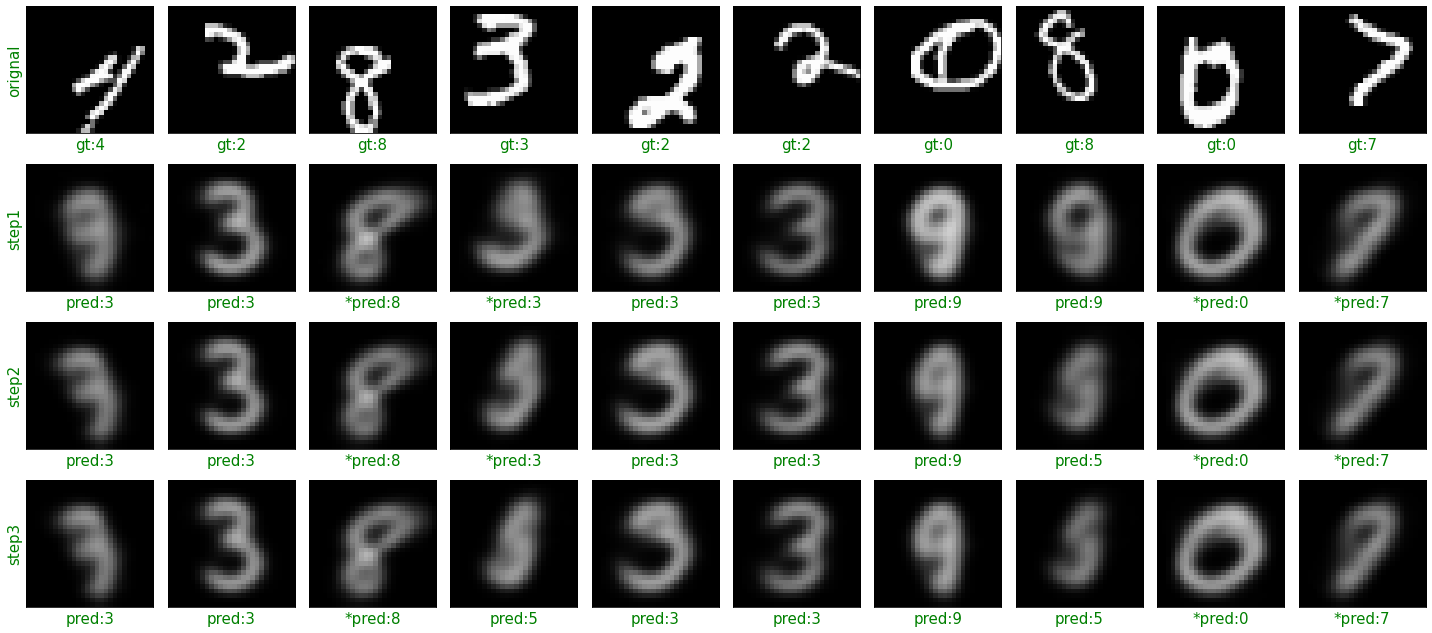



=========================== reconstruction mask =================================


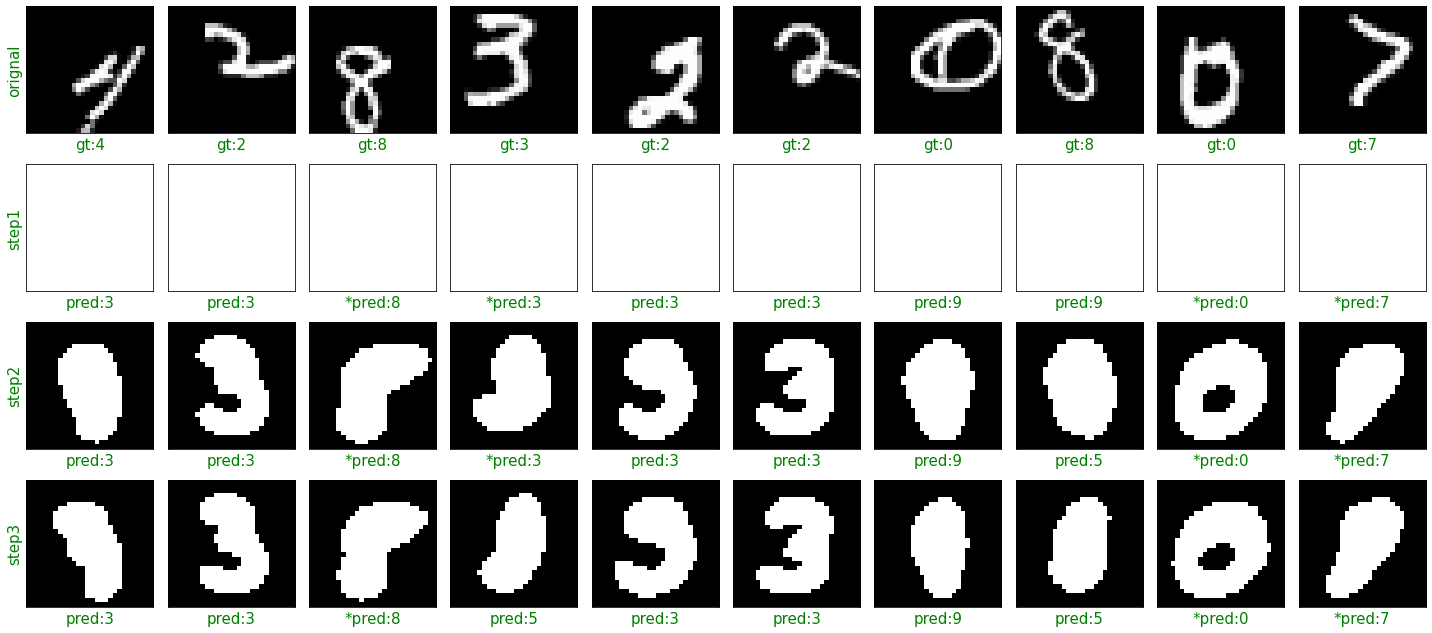



=========================== masked input =================================


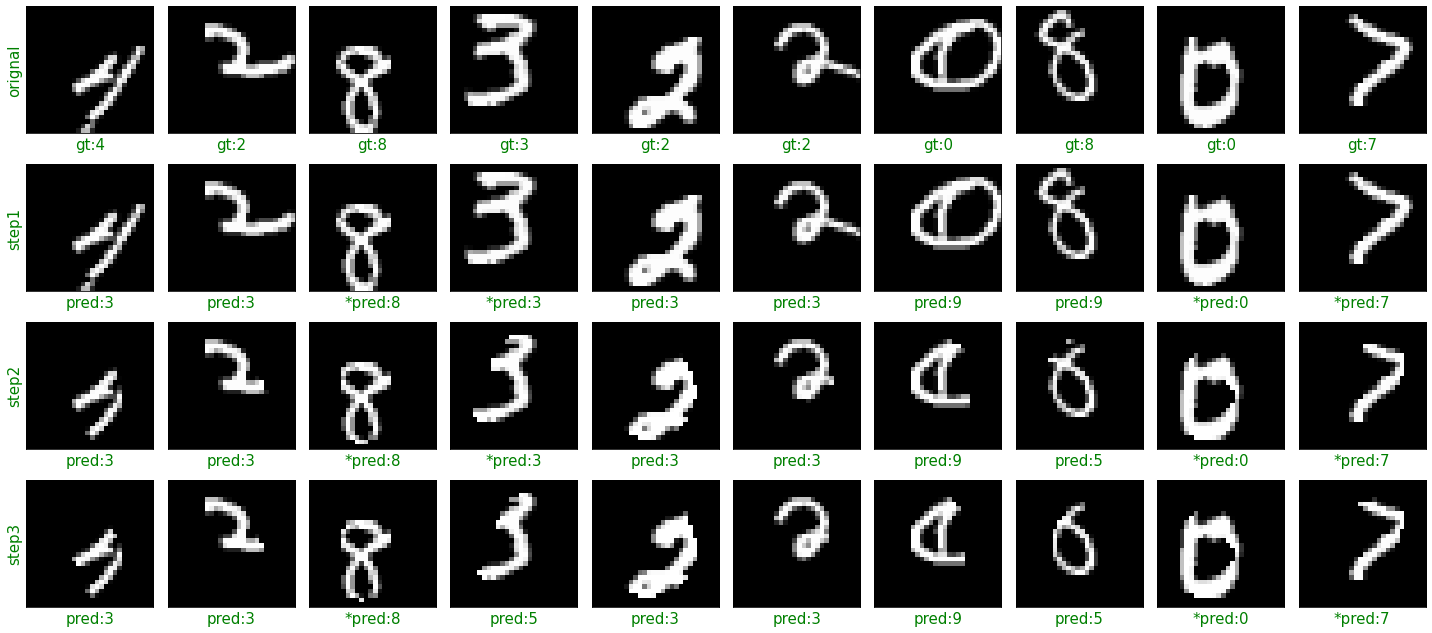

In [5]:
#################################
# if you need separate visualization for each output 
##################################
idx_start = 40 # can't be higher than batchsize
n_image =10

print("\n\n=========================== reconstruction =================================")
visualize_batch(x, y, x_recon_step, objcaps_len_step, include_sum=False, start=idx_start, n_image=n_image)

print("\n\n=========================== reconstruction mask =================================")
visualize_batch(x, y, outputs['x_mask'], objcaps_len_step, start=idx_start, n_image=n_image)

print("\n\n=========================== masked input =================================")
visualize_batch(x, y, outputs['x_input'], objcaps_len_step, start=idx_start, n_image=n_image)